# JFK Flight Delay Prediction

## Load and Prep Flight Delay Data

In [1]:
#Load data (each row represents an hour during the day)
#create a new binary variable identifying hours of the day where on-time gat arrival % is greater than 80%
#create dummy variables for categorical variables
import pandas as pd
import numpy as np
from datetime import datetime as dt

On_Time_Performance = pd.read_csv('On_Time_Performance (1).csv')
On_Time_Performance = On_Time_Performance[On_Time_Performance['Facility']=='JFK']
On_Time_Performance = On_Time_Performance.reset_index()
del On_Time_Performance['index']

On_Time_Performance['Date'] = pd.to_datetime(On_Time_Performance['Date'], errors='coerce')
On_Time_Performance['month'] = On_Time_Performance['Date'].dt.month
On_Time_Performance['weekday'] = On_Time_Performance['Date'].dt.day_name()
On_Time_Performance['80% or More On Time'] = 0
On_Time_Performance.loc[On_Time_Performance['% On-Time Gate Arrivals'] >= 80, '80% or More On Time'] = 1
On_Time_Performance['month'] = On_Time_Performance['month'].apply(str)
On_Time_Performance = pd.get_dummies(On_Time_Performance, drop_first=True)
On_Time_Performance.head()

Date  Hour  Scheduled Departures  Scheduled Arrivals  \
0 2019-06-01   0.0                   8.0                10.0   
1 2019-06-01   1.0                   8.0                 3.0   
2 2019-06-01   2.0                   5.0                 2.0   
3 2019-06-01   3.0                   2.0                 3.0   
4 2019-06-01   4.0                   1.0                 1.0   

   Departures For Metric Computation  Arrivals For Metric Computation  \
0                                9.0                             20.0   
1                                8.0                              6.0   
2                                5.0                              1.0   
3                                0.0                              2.0   
4                                2.0                              0.0   

   % On-Time Gate Departures  % On-Time Airport Departures  \
0                      66.67                         55.56   
1                      75.00                         62.50   
2                     100.00                        100.00   
3                       0.00                          0.00   
4                     100.00                        100.00   

   % On-Time Gate Arrivals  Average Gate Departure Delay  ...  \
0                    40.00                         15.11  ...   
1                    66.67                          9.38  ...   
2                   100.00                          0.80  ...   
3                    50.00                          0.00  ...   
4                     0.00                          2.50  ...   

   Average Gate Arrival Delay  80% or More On Time  month_7  month_8  \
0                       34.20                    0        0        0   
1                       17.83                    0        0        0   
2                       13.00                    1        0        0   
3                       33.00                    0        0        0   
4                        0.00                    0        0        0   

   weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
0               0                 1               0                 0   
1               0                 1               0                 0   
2               0                 1               0                 0   
3               0                 1               0                 0   
4               0                 1               0                 0   

   weekday_Tuesday  weekday_Wednesday  
0                0                  0  
1                0                  0  
2                0                  0  
3                0                  0  
4                0                  0  

[5 rows x 26 columns]

<AxesSubplot: xlabel='Hour'>

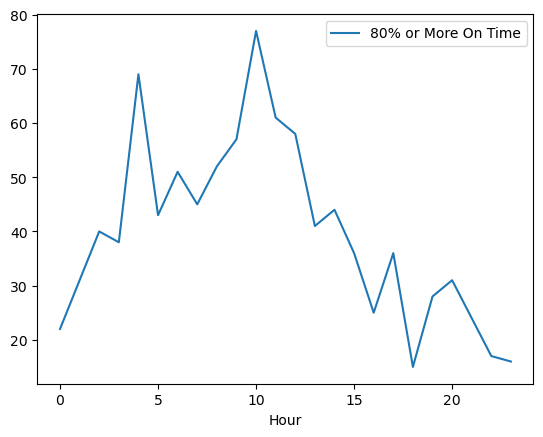

In [2]:
On_Time_Performance.groupby('Hour')[['80% or More On Time']].sum().plot()

In [3]:
#Create seperate dataframes for peak hours (determined based on research and EDA) and off-peak hours
peakHours = On_Time_Performance.loc[((On_Time_Performance['Hour']>=6) & (On_Time_Performance['Hour']<= 9)) | ((On_Time_Performance['Hour'] >= 15) & (On_Time_Performance['Hour']<= 18)) | ((On_Time_Performance['Hour']>= 20)) | ((On_Time_Performance['Hour']<= 1))]
peakHours['Hour'] = peakHours['Hour'].apply(str)
peakHours = pd.get_dummies(peakHours)

offPeak = On_Time_Performance.loc[((On_Time_Performance['Hour']>=2) & (On_Time_Performance['Hour']<= 5)) | ((On_Time_Performance['Hour'] >= 10) & (On_Time_Performance['Hour']<= 14)) | ((On_Time_Performance['Hour']== 19))]
offPeak['Hour'] = offPeak['Hour'].apply(str)
offPeak = pd.get_dummies(offPeak)

peakHours = peakHours.drop(['Average Gate Departure Delay','Average Airport Departure Delay',
                            'Average Gate Arrival Delay','Scheduled Departures', 'Scheduled Arrivals', 
                            'Date', '% On-Time Gate Arrivals',], axis=1)
offPeak = offPeak.drop(['Average Gate Departure Delay','Average Airport Departure Delay',
                        'Average Gate Arrival Delay','Scheduled Departures', 'Scheduled Arrivals', 
                        'Date', '% On-Time Gate Arrivals',], axis=1)


/var/folders/h1/lr9tczdd2xndw8gk7ly58ln80000gn/T/ipykernel_50694/1240213521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peakHours['Hour'] = peakHours['Hour'].apply(str)
/var/folders/h1/lr9tczdd2xndw8gk7ly58ln80000gn/T/ipykernel_50694/1240213521.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offPeak['Hour'] = offPeak['Hour'].apply(str)


## Modelling

In [4]:
#Create a train/test split for both peak and off-peak, target variable is whether flights in that hour were
#80% or more on time
from sklearn.model_selection import train_test_split
peakX_train, peakX_test, peaky_train, peaky_test = train_test_split(peakHours.drop('80% or More On Time',axis=1),
 peakHours['80% or More On Time'], test_size=0.30,
 random_state=101)

offX_train, offX_test, offy_train, offy_test = train_test_split(offPeak.drop('80% or More On Time',axis=1),
 offPeak['80% or More On Time'], test_size=0.30,
 random_state=101)

In [5]:
#Standardize the features
from sklearn.preprocessing import StandardScaler

peakFeatureTrain = peakX_train
offFeatureTrain = offX_train

peakFeatureTest = peakX_test
offFeatureTest = offX_test


sc = StandardScaler()
sc.fit(peakX_train)
peakX_train = sc.transform(peakX_train)
peakX_test = sc.transform(peakX_test)

sc2 = StandardScaler()
sc2.fit(offX_train)
offX_train = sc2.transform(offX_train)
offX_test = sc2.transform(offX_test)

peakX_train = pd.DataFrame(data=peakX_train, columns=peakFeatureTrain.columns)
peakX_test = pd.DataFrame(data=peakX_test, columns=peakFeatureTest.columns)

offX_train = pd.DataFrame(data=offX_train, columns=offFeatureTrain.columns)
offX_test = pd.DataFrame(data=offX_test, columns=offFeatureTest.columns)

# Logistic Regression

### Peak

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

logmodelPeak = LogisticRegression()
logmodelPeak.fit(peakX_train, peaky_train)
predictionsPeak = logmodelPeak.predict(peakX_test)

print(classification_report(peaky_test,predictionsPeak))
print(confusion_matrix(peaky_test, predictionsPeak))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       256
           1       0.62      0.69      0.66       131

    accuracy                           0.75       387
   macro avg       0.73      0.74      0.73       387
weighted avg       0.76      0.75      0.76       387

[[201  55]
 [ 40  91]]


### Off Peak

In [7]:
logmodelOff = LogisticRegression()
logmodelOff.fit(offX_train, offy_train)
predictionsOff = logmodelOff.predict(offX_test)

print(classification_report(offy_test,predictionsOff))
print(confusion_matrix(offy_test, predictionsOff))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65       131
           1       0.68      0.75      0.71       145

    accuracy                           0.68       276
   macro avg       0.69      0.68      0.68       276
weighted avg       0.69      0.68      0.68       276

[[ 80  51]
 [ 36 109]]


### Logistic Regression ROC Curves

In [8]:
#Peak hours AUC score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
peakY_scores = logmodelPeak.decision_function(peakX_test)
fpr, tpr, thresholds = roc_curve(peaky_test, peakY_scores)
auc(fpr, tpr)

0.8376669847328244

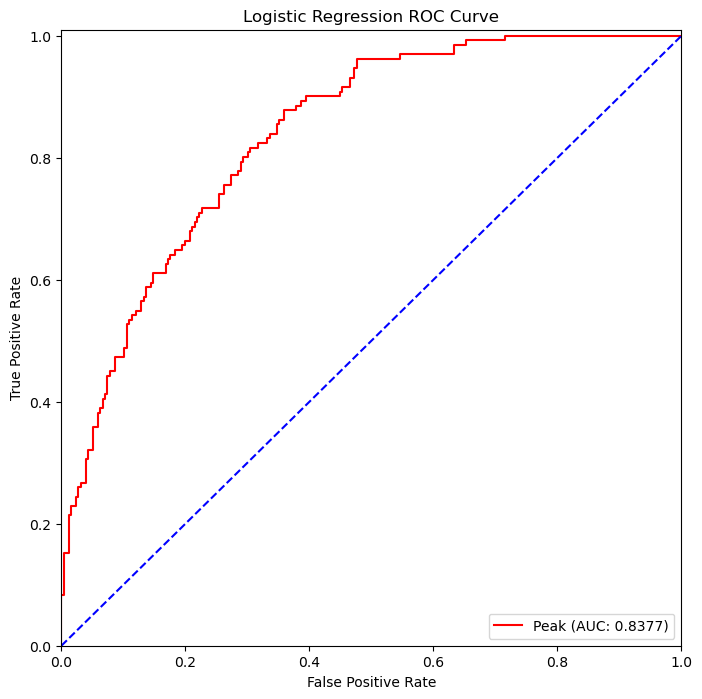

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', label='Peak (AUC: %.4f)'
% auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [10]:
#Off-Peak hours AUC score
offY_scores = logmodelOff.decision_function(offX_test)
fprOff, tprOff, thresholdsOff = roc_curve(offy_test, offY_scores)
offScore = auc(fprOff, tprOff)
offScore

0.7675177678336405

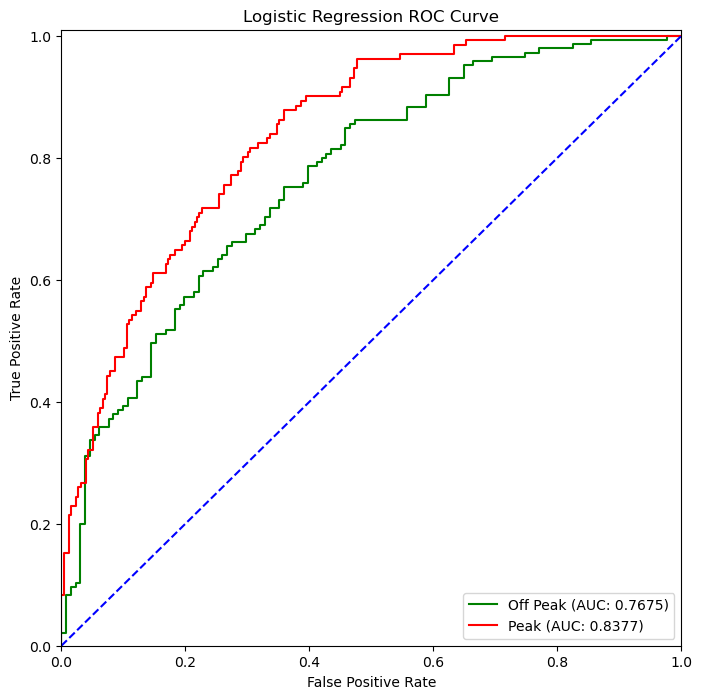

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 8))
plt.plot(fprOff, tprOff, color='green', label='Off Peak (AUC: %.4f)'
% auc(fprOff, tprOff))
plt.plot(fpr, tpr, color='red', label='Peak (AUC: %.4f)'
% auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# KNN

### Peak

In [12]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knnPeak = KNeighborsClassifier()
params_knnPeak = {"n_neighbors": np.arange(1, 25)}
knn_gsPeak = GridSearchCV(knnPeak, params_knnPeak, cv=5)
knn_gsPeak.fit(peakX_train, peaky_train)

knn_bestPeak = knn_gsPeak.best_estimator_
print(knn_gsPeak.best_params_)
knnPredictionsPeak = knn_gsPeak.predict(peakX_test)
print(classification_report(peaky_test,knnPredictionsPeak))
print(confusion_matrix(peaky_test, knnPredictionsPeak))

{'n_neighbors': 12}
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       256
           1       0.53      0.42      0.47       131

    accuracy                           0.68       387
   macro avg       0.63      0.61      0.62       387
weighted avg       0.66      0.68      0.67       387

[[207  49]
 [ 76  55]]


### Off Peak

In [13]:
knnOff = KNeighborsClassifier()
params_knnOff = {"n_neighbors": np.arange(1, 25)}
knn_gsOff = GridSearchCV(knnOff, params_knnOff, cv=5)
knn_gsOff.fit(offX_train, offy_train)


knn_bestOff = knn_gsOff.best_estimator_
print(knn_gsOff.best_params_)
knnPredictionsOff = knn_gsOff.predict(offX_test)
print(classification_report(offy_test,knnPredictionsOff))
print(confusion_matrix(offy_test, knnPredictionsOff))

{'n_neighbors': 22}
              precision    recall  f1-score   support

           0       0.61      0.60      0.60       131
           1       0.64      0.66      0.65       145

    accuracy                           0.63       276
   macro avg       0.63      0.63      0.63       276
weighted avg       0.63      0.63      0.63       276

[[78 53]
 [49 96]]


### KNN ROC Curves

In [14]:
#Peak hours AUC score
y_scoresPeak = knn_gsPeak.predict_proba(peakX_test)
fpr, tpr, threshold = roc_curve(peaky_test, y_scoresPeak[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc

0.7025584446564885

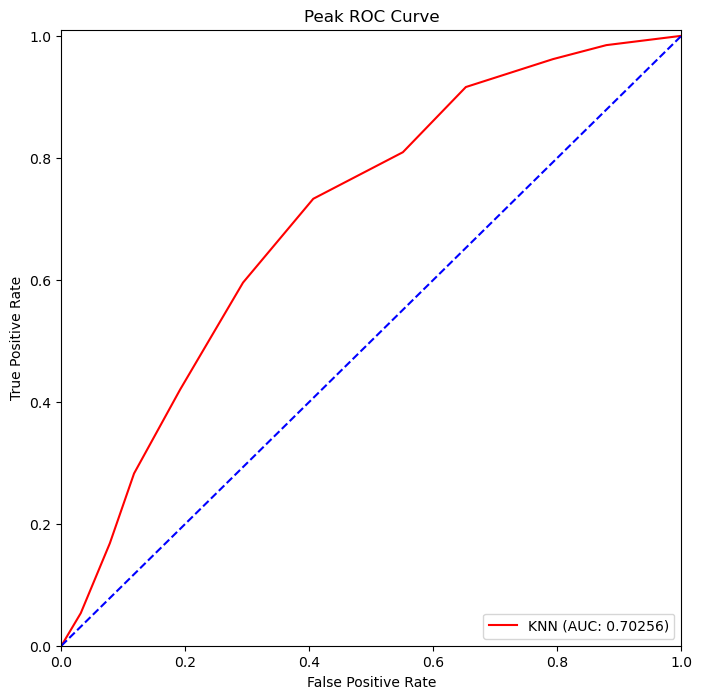

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', label='KNN (AUC: %.5f)'
% auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Peak ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [16]:
#Off-peak hours AUC score
y_scoresOff = knn_gsOff.predict_proba(offX_test)
fprOff, tprOff, thresholdOff = roc_curve(offy_test, y_scoresOff[:, 1])
roc_aucOff = auc(fprOff, tprOff)
roc_aucOff

0.6929191892603317

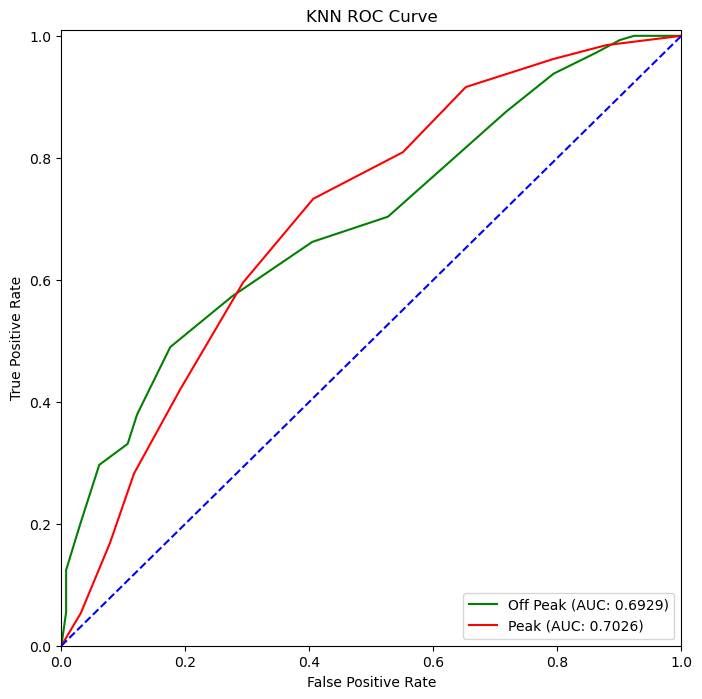

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(fprOff, tprOff, color='green', label='Off Peak (AUC: %.4f)'
% auc(fprOff, tprOff))
plt.plot(fpr, tpr, color='red', label='Peak (AUC: %.4f)'
% auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('KNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Random Forest

### Peak

In [18]:
from sklearn.ensemble import RandomForestClassifier


rfPeak = RandomForestClassifier(random_state=137)
params_rfPeak = {"n_estimators": [50, 100, 200]}
rf_gsPeak = GridSearchCV(rfPeak, params_rfPeak, cv=5)
rf_gsPeak.fit(peakX_train, peaky_train)

rf_bestPeak = rf_gsPeak.best_estimator_
print(rf_gsPeak.best_params_)
rfPredictionsPeak = rf_gsPeak.predict(peakX_test)
print(classification_report(peaky_test,rfPredictionsPeak))
print(confusion_matrix(peaky_test, rfPredictionsPeak))

{'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       256
           1       0.68      0.66      0.67       131

    accuracy                           0.78       387
   macro avg       0.75      0.75      0.75       387
weighted avg       0.78      0.78      0.78       387

[[215  41]
 [ 44  87]]


### Off Peak

In [19]:
rfOff = RandomForestClassifier(random_state=137)
params_rfOff = {"n_estimators": [50, 100, 200]}
rf_gsOff = GridSearchCV(rfOff, params_rfOff, cv=5)
rf_gsOff.fit(offX_train, offy_train)

rf_bestOff = rf_gsOff.best_estimator_
print(rf_gsOff.best_params_)

rfPredictionsOff = rf_gsOff.predict(offX_test)
print(classification_report(offy_test,rfPredictionsOff))
print(confusion_matrix(offy_test, rfPredictionsOff))

{'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       131
           1       0.73      0.81      0.77       145

    accuracy                           0.75       276
   macro avg       0.75      0.74      0.74       276
weighted avg       0.75      0.75      0.74       276

[[ 88  43]
 [ 27 118]]


### Random Forest ROC Curves

In [20]:
#Peak hours AUC score
y_scoresPeak = rf_gsPeak.predict_proba(peakX_test)
fpr, tpr, threshold = roc_curve(peaky_test, y_scoresPeak[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc

0.8426616173664121

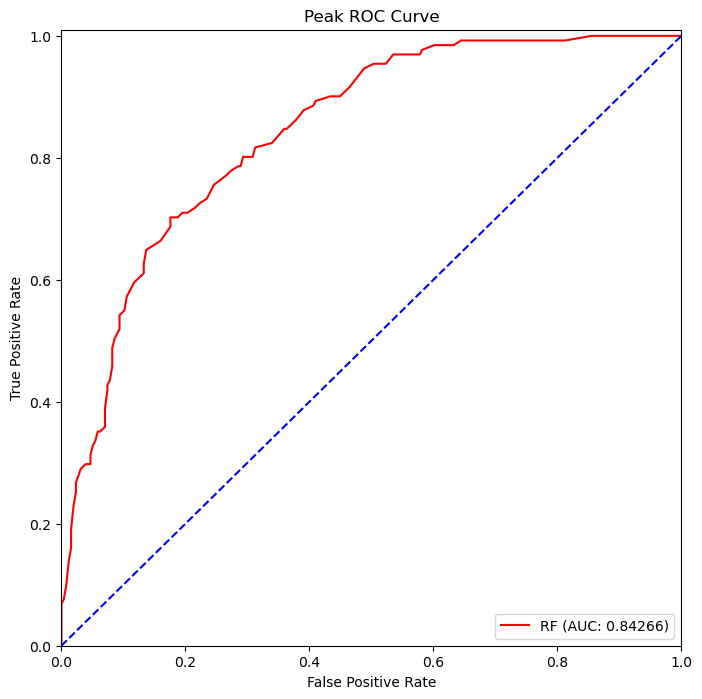

In [21]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='red', label='RF (AUC: %.5f)'
% auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Peak ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [22]:
#Off-peak hours AUC score
y_scoresOff = rf_gsOff.predict_proba(offX_test)
fprOff, tprOff, thresholdOff = roc_curve(offy_test, y_scoresOff[:, 1])
roc_aucOff = auc(fprOff, tprOff)
roc_aucOff

0.8120558041589891

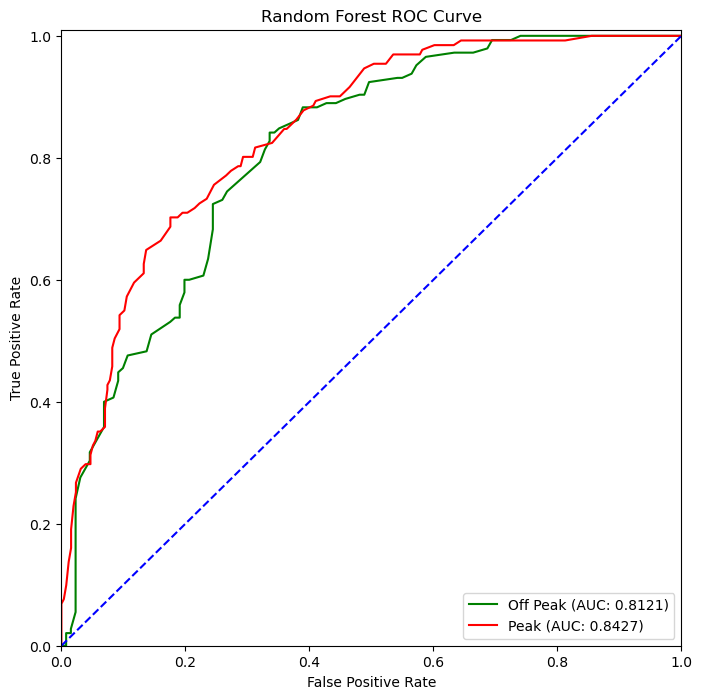

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(fprOff, tprOff, color='green', label='Off Peak (AUC: %.4f)'
% auc(fprOff, tprOff))
plt.plot(fpr, tpr, color='red', label='Peak (AUC: %.4f)'
% auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Random Forest ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Ensemble Model

### Peak

In [24]:
from sklearn.ensemble import VotingClassifier

estimators=[('knn', knn_bestPeak), ('rf', rf_bestPeak), ('log_reg', logmodelPeak)]
ensemblePeak = VotingClassifier(estimators, voting='soft', weights=[1,2,2])

ensemblePeak.fit(peakX_train, peaky_train)
ensemblePeak.score(peakX_test, peaky_test)
ensemblePredictionsPeak = ensemblePeak.predict(peakX_test)
print(classification_report(peaky_test,ensemblePredictionsPeak))
print(confusion_matrix(peaky_test, ensemblePredictionsPeak))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       256
           1       0.64      0.66      0.65       131

    accuracy                           0.76       387
   macro avg       0.73      0.74      0.74       387
weighted avg       0.76      0.76      0.76       387

[[208  48]
 [ 44  87]]


### Off Peak

In [25]:
estimators=[('knn', knn_bestOff), ('rf', rf_bestOff), ('log_reg', logmodelOff)]
ensembleOff = VotingClassifier(estimators, voting='soft')

ensembleOff.fit(offX_train, offy_train)
ensembleOff.score(offX_test, offy_test)
ensemblePredictionsOff = ensembleOff.predict(offX_test)

print(classification_report(offy_test,ensemblePredictionsOff))
print(confusion_matrix(offy_test, ensemblePredictionsOff))

              precision    recall  f1-score   support

           0       0.73      0.63      0.68       131
           1       0.71      0.79      0.75       145

    accuracy                           0.72       276
   macro avg       0.72      0.71      0.71       276
weighted avg       0.72      0.72      0.72       276

[[ 83  48]
 [ 30 115]]


### Ensemble ROC Curves

No Skill: ROC AUC=0.50000
Ensemble: ROC AUC=0.84080


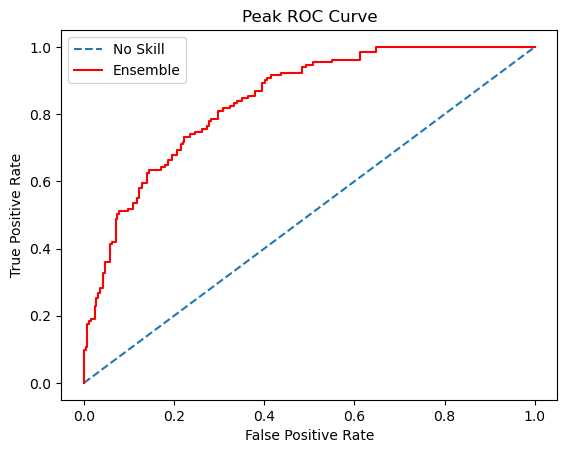

In [26]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(peaky_test))]

lr_probs = ensemblePeak.predict_proba(peakX_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(peaky_test, ns_probs)
lr_auc = roc_auc_score(peaky_test, lr_probs)

print('No Skill: ROC AUC=%.5f' % (ns_auc))
print('Ensemble: ROC AUC=%.5f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(peaky_test, ns_probs)
lr_fpr, lr_tpr, _off = roc_curve(peaky_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, color='red', label='Ensemble')

plt.title('Peak ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

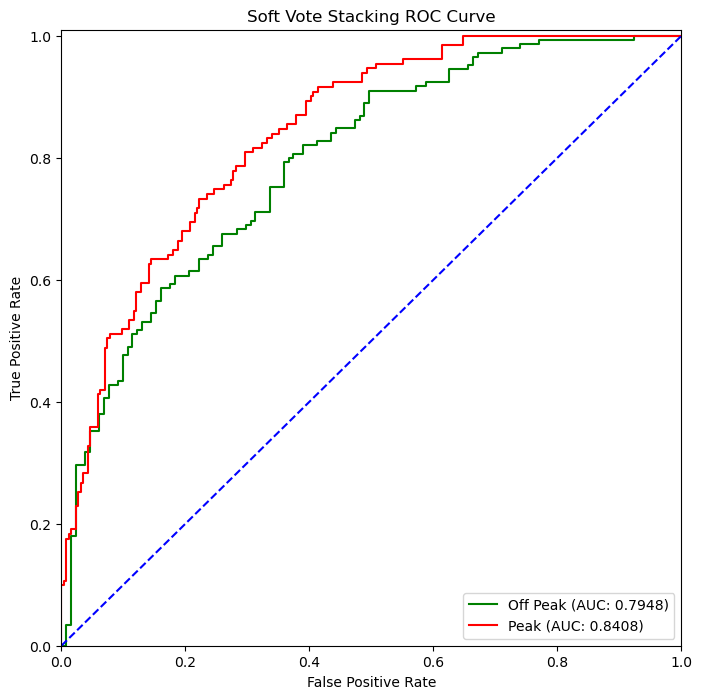

In [27]:
ns_probsoff = [0 for _ in range(len(offy_test))]
lr_probsoff = ensembleOff.predict_proba(offX_test)
lr_probsoff = lr_probsoff[:, 1]
lr_aucoff = roc_auc_score(offy_test, lr_probsoff)
lr_fproff, lr_tproff, _off = roc_curve(offy_test, lr_probsoff)

plt.figure(figsize=(8, 8))
plt.plot(lr_fproff, lr_tproff, color='green', label='Off Peak (AUC: %.4f)'
% auc(lr_fproff, lr_tproff))
plt.plot(lr_fpr, lr_tpr, color='red', label='Peak (AUC: %.4f)'
% auc(lr_fpr, lr_tpr))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Soft Vote Stacking ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Feature Importances and Model Interpretation for Random Forest

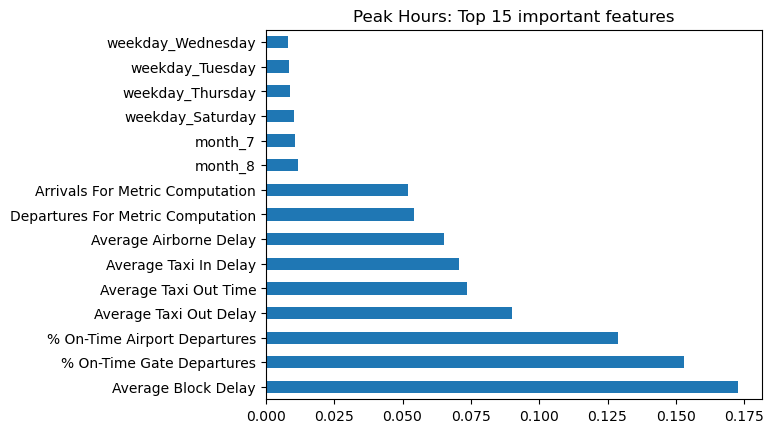

In [28]:
rfPeak.fit(peakX_train, peaky_train)
feat_importances = pd.Series(rfPeak.feature_importances_, index=peakX_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Peak Hours: Top 15 important features")
plt.show()

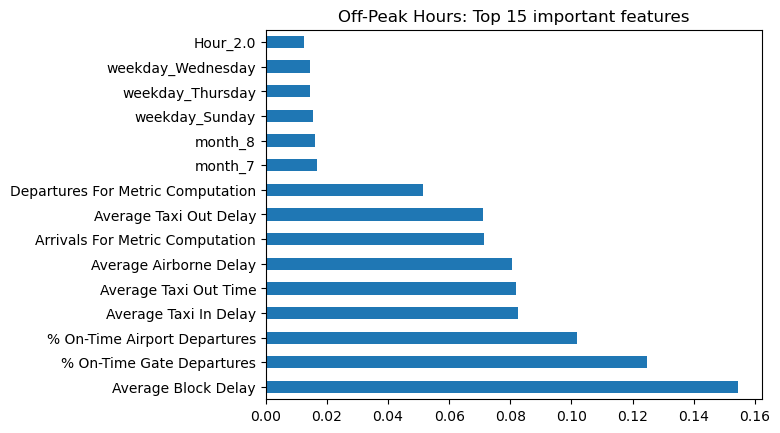

In [29]:
rfOff.fit(offX_train, offy_train)
feat_importances = pd.Series(rfOff.feature_importances_, index=offX_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Off-Peak Hours: Top 15 important features")
plt.show()

In [30]:
import lime
import lime.lime_tabular

predict_fn_rf = lambda x: rf_gsPeak.predict_proba(x).astype(float)
X = peakX_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = peakX_train.columns,class_names=['< 80%','>= 80%'],kernel_width=5)

In [31]:
choosen_instance = peakX_test.iloc[[374]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

/Users/mhgrody/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [32]:
choosen_instance = peakX_test.iloc[[39]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

/Users/mhgrody/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [33]:
predict_fn_rf2 = lambda x: rf_gsOff.predict_proba(x).astype(float)
X2 = offX_train.values
explainer2 = lime.lime_tabular.LimeTabularExplainer(X2,feature_names = offX_train.columns,class_names=['< 80%','>= 80%'],kernel_width=5)

In [34]:
choosen_instance = offX_test.iloc[[74]].values[0]
exp = explainer2.explain_instance(choosen_instance, predict_fn_rf2,num_features=10)
exp.show_in_notebook(show_all=False)

/Users/mhgrody/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
